In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import sklearn
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model.coordinate_descent import ConvergenceWarning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier#KNN
from sklearn.preprocessing import label_binarize
from sklearn import metrics

In [2]:
## 设置字符集，防止中文乱码
mpl.rcParams['font.sans-serif']=[u'simHei']
mpl.rcParams['axes.unicode_minus']=False
## 拦截异常
warnings.filterwarnings(action = 'ignore', category=ConvergenceWarning)

In [3]:
## 数据加载
path = "datas/iris.data"
names = ['sepal length', 'sepal width', 'petal length', 'petal width', 'cla']
df = pd.read_csv(path, header=None, names=names)
print(df['cla'].value_counts())
df.head()

Iris-setosa        50
Iris-virginica     50
Iris-versicolor    50
Name: cla, dtype: int64


,sepal length,sepal width,petal length,petal width,cla
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
def parseRecord(record):
    result=[]
    r = zip(names,record)
    for name,v in r:
        if name == 'cla':
            if v == 'Iris-setosa':
                result.append(1)
            elif v == 'Iris-versicolor':
                result.append(2)
            elif v == 'Iris-virginica':
                result.append(3)
            else:
                result.append(np.nan)
        else:
            result.append(float(v))
    return result

In [5]:
### 1. 数据转换为数字以及分割
## 数据转换
#datas = df.apply(lambda r: parseRecord(r), axis=1) 
df['cla'] = pd.Categorical(df['cla']).codes
#df['cla'] = df['cla'] + 1   #以0,1,2分类的方式容易影响到AUC的值，以1,2,3的方式比较好
def transform(x):
    return map(float,x)
datas = df.apply(lambda x: pd.Series(transform(x),index=names),axis=1)
print(datas.head())

print(df['cla'].value_counts())
## 异常数据删除
datas = df.dropna(how='any')

## 数据分割
X = datas[names[0:-1]]
Y = datas[names[-1]]
## 数据抽样(训练数据和测试数据分割)
X_train,X_test,Y_train,Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

   sepal length  sepal width  petal length  petal width  cla
0           5.1          3.5           1.4          0.2  0.0
1           4.9          3.0           1.4          0.2  0.0
2           4.7          3.2           1.3          0.2  0.0
3           4.6          3.1           1.5          0.2  0.0
4           5.0          3.6           1.4          0.2  0.0
2    50
1    50
0    50
Name: cla, dtype: int64


In [6]:
print ("原始数据条数:%d；训练数据条数:%d；特征个数:%d；测试样本条数:%d" % (len(X), len(X_train), X_train.shape[1], X_test.shape[0]))

原始数据条数:150；训练数据条数:90；特征个数:4；测试样本条数:60


In [7]:
### 2. 数据标准化
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [8]:
### 3. 特征选择(这里不进行特征选择操作)

In [9]:
### 4. 降维处理(这里不做降维处理)

In [10]:
### 5. 模型构建
lr = LogisticRegressionCV(Cs=np.logspace(-4,1,50), cv=3,fit_intercept=True, penalty='l2', solver='lbfgs', tol=0.01, multi_class='multinomial')
#solver：‘newton-cg’,'lbfgs','liblinear','sag'  default:liblinear
#'sag'=mini-batch
#'multi_clss':
lr.fit(X_train, Y_train)

LogisticRegressionCV(Cs=array([1.00000e-04, 1.26486e-04, 1.59986e-04, 2.02359e-04, 2.55955e-04,
       3.23746e-04, 4.09492e-04, 5.17947e-04, 6.55129e-04, 8.28643e-04,
       1.04811e-03, 1.32571e-03, 1.67683e-03, 2.12095e-03, 2.68270e-03,
       3.39322e-03, 4.29193e-03, 5.42868e-03, 6.86649e-03, 8.68511e-03,
       1...., 2.44205e+00, 3.08884e+00,
       3.90694e+00, 4.94171e+00, 6.25055e+00, 7.90604e+00, 1.00000e+01]),
           class_weight=None, cv=3, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='multinomial',
           n_jobs=1, penalty='l2', random_state=None, refit=True,
           scoring=None, solver='lbfgs', tol=0.01, verbose=0)

In [11]:
### 6. 模型效果输出
## 将正确的数据转换为矩阵形式
y_test_hot = label_binarize(Y_test,classes=(0,1,2))
## 得到预测的损失值
lr_y_score = lr.decision_function(X_test)
print(lr_y_score)
## 计算roc的值
lr_fpr, lr_tpr, lr_threasholds = metrics.roc_curve(y_test_hot.ravel(),lr_y_score.ravel())
#threasholds阈值
## 计算auc的值
lr_auc = metrics.auc(lr_fpr, lr_tpr)
print ("Logistic算法R值：", lr.score(X_train, Y_train))
print ("Logistic算法AUC值：", lr_auc)
### 7. 模型预测
lr_y_predict = lr.predict(X_test)

[[ -6.27937676   1.05548892   5.22388784]
 [ -2.5371109    4.02213826  -1.48502736]
 [  9.58561223   2.6059998  -12.19161203]
 [ -8.18346495   2.6530125    5.53045244]
 [  8.06522513   3.206342   -11.27156713]
 [ -7.22184333   0.48250241   6.73934092]
 [  8.3061655    2.99869891 -11.30486441]
 [ -3.63926189   2.64337134   0.99589054]
 [ -4.44558943   3.22131538   1.22427405]
 [ -1.96604656   2.94686917  -0.98082261]
 [ -4.96636124   2.69911013   2.26725111]
 [ -2.62637732   2.30702815   0.31934917]
 [ -2.60962466   2.90343809  -0.29381343]
 [ -4.0043684    2.89099073   1.11337767]
 [ -2.93851571   2.52286105   0.41565466]
 [  7.70822708   3.63929131 -11.34751839]
 [ -2.8118009    2.36157169   0.4502292 ]
 [ -1.8045935    2.73019664  -0.92560314]
 [  7.12845508   3.45997993 -10.58843501]
 [  8.46288289   2.68843117 -11.15131406]
 [ -4.49448454   1.43394608   3.06053846]
 [ -1.91130978   1.89262974   0.01868004]
 [  7.84043823   2.94114447 -10.7815827 ]
 [  7.78617371   3.37763355 -11.16

In [12]:
##### KNN算法实现
# a. 模型构建
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, Y_train)

# b. 模型效果输出
## 将正确的数据转换为矩阵形式
y_test_hot = label_binarize(Y_test,classes=(0,1,2)) #classes表示要分成0,1,2三类，将测试集数据转成矩阵形式
## 得到预测的概率值
knn_y_score = knn.predict_proba(X_test) #对测试集进行准确率评估
## 计算roc的值
knn_fpr, knn_tpr, knn_threasholds = metrics.roc_curve(y_test_hot.ravel(),knn_y_score.ravel()) #必须先真实值，后预测值
## 计算auc的值
knn_auc = metrics.auc(knn_fpr, knn_tpr)
print ("KNN算法准确率：", knn.score(X_train, Y_train))
print ("KNN算法AUC值：", knn_auc)

# c. 模型预测
knn_y_predict = knn.predict(X_test) #对测试集进行评估预测
knn_y_score #对应每种分类的评估概率

[[0 0 1]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 0 1]]
KNN算法R值： 0.9777777777777777
KNN算法AUC值： 0.9694444444444446


array([[0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.33333333, 0.66666667],
       [0.        , 1.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.66666667, 0.33333333],
       [0.        , 1.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.        ],
       [1.

In [13]:
print(knn_fpr)

[0.         0.01666667 0.03333333 0.1        1.        ]


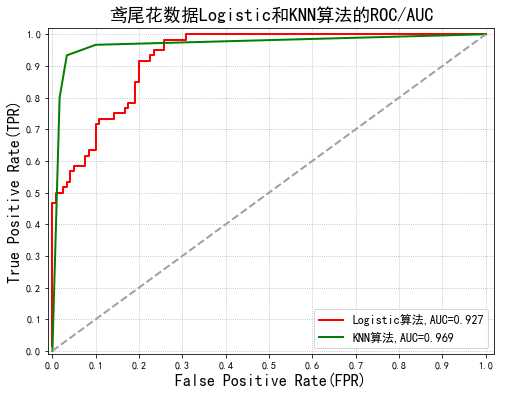

In [14]:
## 画图1：ROC曲线画图
plt.figure(figsize=(8, 6), facecolor='w')
plt.plot(lr_fpr,lr_tpr,c='r',lw=2,label=u'Logistic算法,AUC=%.3f' % lr_auc)
plt.plot(knn_fpr,knn_tpr,c='g',lw=2,label=u'KNN算法,AUC=%.3f' % knn_auc)
plt.plot((0,1),(0,1),c='#a0a0a0',lw=2,ls='--')
plt.xlim(-0.01, 1.02)#设置X轴的最大和最小值
plt.ylim(-0.01, 1.02)#设置y轴的最大和最小值
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('False Positive Rate(FPR)', fontsize=16)
plt.ylabel('True Positive Rate(TPR)', fontsize=16)
plt.grid(b=True, ls=':')
plt.legend(loc='lower right', fancybox=True, framealpha=0.8, fontsize=12)
plt.title(u'鸢尾花数据Logistic和KNN算法的ROC/AUC', fontsize=18)
plt.show()

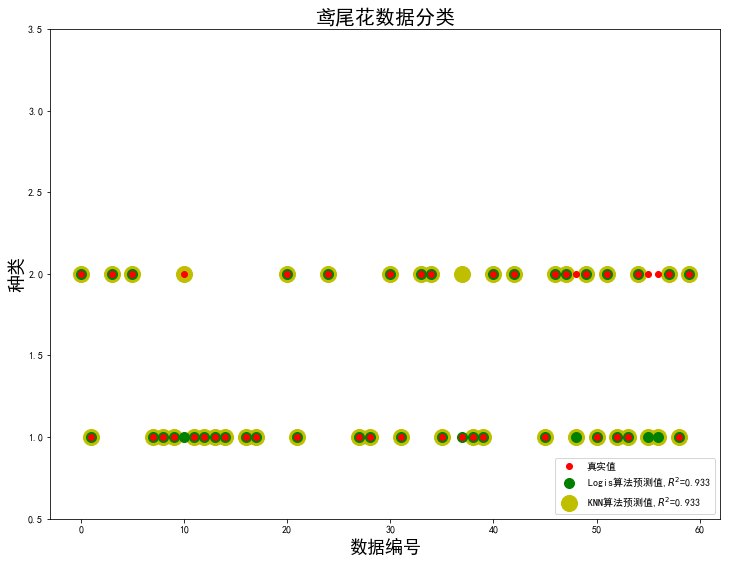

In [15]:
## 画图2：预测结果画图
x_test_len = range(len(X_test))
plt.figure(figsize=(12, 9), facecolor='w')
plt.ylim(0.5,3.5)
plt.plot(x_test_len, Y_test, 'ro',markersize = 6, zorder=3, label=u'真实值')
plt.plot(x_test_len, lr_y_predict, 'go', markersize = 10, zorder=2, label=u'Logis算法预测值,$R^2$=%.3f' % lr.score(X_test, Y_test))
plt.plot(x_test_len, knn_y_predict, 'yo', markersize = 16, zorder=1, label=u'KNN算法预测值,$R^2$=%.3f' % knn.score(X_test, Y_test))
plt.legend(loc = 'lower right')
plt.xlabel(u'数据编号', fontsize=18)
plt.ylabel(u'种类', fontsize=18)
plt.title(u'鸢尾花数据分类', fontsize=20)
plt.show()
